# **XGBoost model**

This notebook builds a **machine learning model to estimate the probability** that the blue fighter will win a given match. The goal is to generate an independent, well-calibrated probability that reflects the **real chance of victory** based on fighter statistics and matchup features — without using or being influenced by the betting market odds. These model-generated probabilities can **later be compared with the bookmaker's implied odds to identify potential value bets**.

#### **Loading data**

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score

# Load processed dataset
train_df = pd.read_csv('data/training_data.csv')
test_df = pd.read_csv('data/testing_data.csv')
testing_odds = pd.read_csv('data/testing_odds.csv')

#### **Lasts checks**

In [2]:
training_features = set(train_df.columns)
testing_features = set(test_df.columns)

# Ensure both datasets have the same features
print('Features in training set but not in testing set:', training_features.difference(testing_features))
print('Features in testing set but not in training set:', testing_features.difference(training_features))

# Let's add these features to the test set
missing_features = training_features.difference(testing_features)
for feature in missing_features:
	test_df[feature] = 0

# Sort the columns in the same order
test_df = test_df[train_df.columns]

# Check the columns match
print('The columns are the same ->', set(train_df.columns) == set(test_df.columns))

print('Variables:', list(train_df.columns))

Features in training set but not in testing set: set()
Features in testing set but not in training set: set()
The columns are the same -> True
Variables: ['TitleBout', 'NumberOfRounds', 'BlueCurrentLoseStreak', 'BlueCurrentWinStreak', 'BlueDraws', 'BlueAvgSigStrLanded', 'BlueAvgSigStrPct', 'BlueAvgSubAtt', 'BlueAvgTDLanded', 'BlueAvgTDPct', 'BlueLongestWinStreak', 'BlueLosses', 'BlueTotalRoundsFought', 'BlueTotalTitleBouts', 'BlueWinsByDecisionMajority', 'BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous', 'BlueWinsByKO', 'BlueWinsBySubmission', 'BlueWinsByTKODoctorStoppage', 'BlueWins', 'BlueHeightCms', 'BlueReachCms', 'BlueWeightLbs', 'RedCurrentLoseStreak', 'RedCurrentWinStreak', 'RedDraws', 'RedAvgSigStrLanded', 'RedAvgSigStrPct', 'RedAvgSubAtt', 'RedAvgTDLanded', 'RedAvgTDPct', 'RedLongestWinStreak', 'RedLosses', 'RedTotalRoundsFought', 'RedTotalTitleBouts', 'RedWinsByDecisionMajority', 'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous', 'RedWinsByKO', 'RedWinsBySubmissio

#### **Benchmarking**

In [3]:
def profit(df, bet_amount, name_col):
    profit = 0
    for index, row in df.iterrows():
        if row[name_col] is not None:
            if row[name_col] == row['BlueWin']:
                if row[name_col] == 1:
                    profit += bet_amount * (row['BlueDecOdds'] - 1)
                else:
                    profit += bet_amount * (row['RedDecOdds'] - 1)
            else:
                profit -= bet_amount
    return profit

In [4]:
# We will compare our new model to a benchmark model that suggests to bet on the fighter with the highest probability of winning.
# Our objective will be to improve the benchmark model by using a machine learning model to predict the probabilities of winning.
df_bench = test_df.copy()
conditions, choices = [df_bench['Prob_BlueWin_Bet'] > 0.5, df_bench['Prob_BlueWin_Bet'] <= 0.5], [1, 0]
df_bench['Bet_benchmark'] = np.select(conditions, choices, default = None)

# First, let's add the decimal odds back to the test_df for reference. For this, you need to know Decimal_odds = (expected_value + 100) / 100 (it is explained in the EDA notebook)
df_bench['RedDecOdds'] = (testing_odds['RedExpectedValue'] + 100) / 100
df_bench['BlueDecOdds'] = (testing_odds['BlueExpectedValue'] + 100) / 100

print('Profit of the bets according to the benchmark model: $', profit(df_bench, 100, 'Bet_benchmark'))

Profit of the bets according to the benchmark model: $ 23230.868599256468


#### **Creating, training and evaluating the model**

In [5]:
# Separate features and target
X_train = train_df.drop(columns = ['Prob_BlueWin_Bet', 'BlueWin'])
y_train = train_df['BlueWin']

X_test = test_df.drop(columns=['Prob_BlueWin_Bet', 'BlueWin'])
y_test = test_df['BlueWin']

In [6]:
# Create and tune the model parameters with GridSearchCV
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

param_grid = {
	'n_estimators': [190, 200, 210],
	'learning_rate': [0.06, 0.08, 0.1],
	'max_depth': [3, 4, 5],
	'subsample': [0.7, 0.8, 0.9]
}

grid = GridSearchCV(model, param_grid, scoring='neg_log_loss', cv=3, verbose=1, n_jobs=-1)

# Train the model on new data
grid.fit(X_train, y_train)
y_pred_proba = grid.predict_proba(X_test)[:, 1]

# Evaluation
print('Log Loss:', log_loss(y_test, y_pred_proba))
print('Brier Score:', brier_score_loss(y_test, y_pred_proba))
print('AUC:', roc_auc_score(y_test, y_pred_proba))

# Add the predicted probabilities to the test DataFrame
test_df['Prob_BlueWin_Model'] = y_pred_proba


# Show the best parameters found by GridSearchCV
print('Best parameters found:', grid.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Log Loss: 0.6291086440443617
Brier Score: 0.22059030522123194
AUC: 0.6998503355380679
Best parameters found: {'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 190, 'subsample': 0.9}


#### **Evaluating the possible bet value**

In [7]:
# First, let's add the decimal odds back to the test_df for reference. For this, you need to know Decimal_odds = (expected_value + 100) / 100 (it is explained in the EDA notebook)
test_df['RedDecOdds'] = (testing_odds['RedExpectedValue'] + 100) / 100
test_df['BlueDecOdds'] = (testing_odds['BlueExpectedValue'] + 100) / 100

# Then, let's see the first few rows of the test_df to
print(test_df[['Prob_BlueWin_Bet', 'Prob_BlueWin_Model']].head())

# Create a column called 'Bet' that indicates if the model suggests to bet on BlueFighter (1), RedFighter (0), or not betting based on a threshold (th) and bet expected value
th = 0.05

ev_blue = test_df['Prob_BlueWin_Model'] * (test_df['BlueDecOdds'] - 1) - (1 - test_df['Prob_BlueWin_Model'])
ev_red = (1 - test_df['Prob_BlueWin_Model']) * (test_df['RedDecOdds'] - 1) - test_df['Prob_BlueWin_Model']

test_df['Bet'] = np.where(ev_blue > th, 1, np.where(ev_red > th, 0, np.nan))

   Prob_BlueWin_Bet  Prob_BlueWin_Model
0          0.195707            0.267874
1          0.410621            0.523532
2          0.393258            0.566817
3          0.811518            0.670691
4          0.558797            0.462435


In [8]:
# Finally, let's see the results with the betting suggestions and the results
test_df[['Prob_BlueWin_Bet', 'Prob_BlueWin_Model', 'RedDecOdds', 'BlueDecOdds', 'Bet', 'BlueWin']].head(7)

,Prob_BlueWin_Bet,Prob_BlueWin_Model,RedDecOdds,BlueDecOdds,Bet,BlueWin
0,0.195707,0.267874,1.966582,2.650546,0.0,0
1,0.410621,0.523532,1.192308,4.900000,1.0,0
2,0.393258,0.566817,1.602410,2.300000,1.0,1
3,0.811518,0.670691,1.555556,2.400000,1.0,1
4,0.558797,0.462435,5.000000,1.161290,0.0,1
5,0.314607,0.281998,2.140000,1.689655,0.0,0
6,0.255034,0.153724,1.400000,3.050000,0.0,0


#### **Evaluating the reliability of the model**

In [9]:
# Let's see the results of bets suggested by the model
right = test_df[(test_df['Bet'] == 1) & (test_df['BlueWin'] == 1)].shape[0] + test_df[(test_df['Bet'] == 0) & (test_df['BlueWin'] == 0)].shape[0]
wrong = test_df[(test_df['Bet'] == 1) & (test_df['BlueWin'] == 0)].shape[0] + test_df[(test_df['Bet'] == 0) & (test_df['BlueWin'] == 1)].shape[0]

print('Number of fights to be decided:', test_df.shape[0])
print('Number of bets suggested by the model that got it right:', right)
print('Number of bets suggested by the model that got it wrong:', wrong)
print('Number of bets suggested by the model:', right + wrong)
print('Number of bets suggested by the model as None:', test_df[test_df['Bet'].isnull()].shape[0], '\n')
print('Then, the accuracy of the model is:', right / (right + wrong))

Number of fights to be decided: 500
Number of bets suggested by the model that got it right: 272
Number of bets suggested by the model that got it wrong: 176
Number of bets suggested by the model: 448
Number of bets suggested by the model as None: 52 

Then, the accuracy of the model is: 0.6071428571428571


#### **Optimizing the threshold**

In [10]:
# To optimize the threshold to maximize the profit, we can iterate over a range of thresholds and margins
thresholds = np.arange(0, 0.51, 0.05)
parameters = []
for th in thresholds:
	# Define the conditions for betting based on the current threshold and margin
	ev_blue = test_df['Prob_BlueWin_Model'] * (test_df['BlueDecOdds'] - 1) - (1 - test_df['Prob_BlueWin_Model'])
	ev_red = (1 - test_df['Prob_BlueWin_Model']) * (test_df['RedDecOdds'] - 1) - test_df['Prob_BlueWin_Model']

	# Apply the conditions to create the 'Bet' column
	test_df['Bet'] = np.where(ev_blue > th, 1, np.where(ev_red > th, 0, np.nan))

	# Calculate the profit and accuracy for the current threshold and margin
	current_profit = profit(test_df, 100, 'Bet')
	
	try:
		accuracy = (test_df[test_df['Bet'] == test_df['BlueWin']].shape[0]) / (test_df.shape[0] - test_df[test_df['Bet'].isnull()].shape[0])
	except:
		accuracy = 0
	
	# Store the profit, threshold, margin and accuracy
	parameters.append((th, current_profit, accuracy))

# Find the best result
best_th, best_profit, best_accuracy = max(parameters, key=lambda x: x[1])

# Print the best profit, threshold, margin and accuracy
print('Best profit: $', best_profit)
print('Best threshold:', best_th)
print('Best accuracy:', best_accuracy)

Best profit: $ 29650.34890044063
Best threshold: 0.0
Best accuracy: 0.608421052631579


#### **Calculations**

In [11]:
# Let's see what the individual bets would have been with the best threshold

# We need to apply the best threshold to the test_df
ev_blue = test_df['Prob_BlueWin_Model'] * (test_df['BlueDecOdds'] - 1) - (1 - test_df['Prob_BlueWin_Model'])
ev_red = (1 - test_df['Prob_BlueWin_Model']) * (test_df['RedDecOdds'] - 1) - test_df['Prob_BlueWin_Model']
test_df['Bet'] = np.where(ev_blue > best_th, 1, np.where(ev_red > best_th, 0, np.nan))

# Now, let's create a list with the individual results of the bets suggested by the model
bet_results = list()
for index, row in test_df.iterrows():
    if row['Bet'] is not None:
        if row['Bet'] == row['BlueWin']:
            if row['Bet'] == 1:
                bet_results.append(100 * (row['BlueDecOdds'] - 1))
            else:
                bet_results.append(100 * (row['RedDecOdds'] - 1))
        else:
            bet_results.append(-100)

# Let's print the mean and standard deviation of the individual results
print('Mean of individual bet results: $', np.mean(bet_results))
print('Standard deviation of individual bet results: $', np.std(bet_results), '\n')

# Print the number of bets suggested by the model that got it right and wrong
right = test_df[(test_df['Bet'] == 1) & (test_df['BlueWin'] == 1)].shape[0] + test_df[(test_df['Bet'] == 0) & (test_df['BlueWin'] == 0)].shape[0]
wrong = test_df[(test_df['Bet'] == 1) & (test_df['BlueWin'] == 0)].shape[0] + test_df[(test_df['Bet'] == 0) & (test_df['BlueWin'] == 1)].shape[0]

print('Number of fights to be decided:', test_df.shape[0])
print('Number of bets suggested by the model that got it right:', right)
print('Number of bets suggested by the model that got it wrong:', wrong)
print('Number of bets suggested by the model:', right + wrong)
print('Number of bets suggested by the model as None:', test_df[test_df['Bet'].isnull()].shape[0], '\n')

print('Then, the accuracy of the model (or proportion) is: 0.608421, the proportion of right guesses by the model is: 263 / 380, and the net profit is: $', best_profit)

Mean of individual bet results: $ 59.3006978008813
Standard deviation of individual bet results: $ 171.85762104427198 

Number of fights to be decided: 500
Number of bets suggested by the model that got it right: 289
Number of bets suggested by the model that got it wrong: 186
Number of bets suggested by the model: 475
Number of bets suggested by the model as None: 25 

Then, the accuracy of the model (or proportion) is: 0.608421, the proportion of right guesses by the model is: 263 / 380, and the net profit is: $ 29650.34890044063


Let's see $CI_{p}^{99\%}$ with the proportion given $p = \dfrac{289}{475} = 0.608421$

$CI_{p}^{99\%} = [p - z^{0.005} \sqrt{\dfrac{\frac{289}{475} (1 - \frac{289}{475})}{475}}, p + z^{0.005} \sqrt{\dfrac{\frac{289}{475} (1 - \frac{289}{475})}{475}}] = [0.550752, 0.666090]$

Now it's time to analyze $CI_{mean\_profit}^{99\%} = [54.3007 - z^{0.005} \dfrac{171.8576}{\sqrt{475}}, 54.3007 + z^{0.005} \dfrac{171.8576}{\sqrt{475}}] = [33.9959, 74.6055]$

This means that if we were to repeat this betting strategy many times under similar conditions, we would expect the model's accuracy to fall between 55.0752% and 66.6090% in 99% of those repetitions, and the individual bet profit to fall between $33.9959 and $74.6055.

In ohter words: `We are 99% confident that the model’s true accuracy lies between 55.0752% and 66.6090% and its individual bet profit between $33.9959 and $74.6055.`

Now, let's see what the ROI would be:

$ROI = \dfrac{\text{Net profit}}{\text{Investment}} = \dfrac{29650.3489}{475 \cdot 100} = 0.624218$

The model achieved a **Return on Investment** ($ROI$) of approximately **0.625**, which is great! This means, in practical terms, if you had invested $\$1000$ as a total investment amount, you would have ended up with $\$1625$.

This is a **strong performance**, especially in the context of sports betting, where profitable long-term strategies are rare.

What if we could summarize all betting odds into one?

$Final\_Odd = \dfrac{\text{Net profit + Investment}}{\text{Investment}} = \dfrac{29650.3489 + (475 \cdot 100)}{475 \cdot 100} = 1.6242 = ROI + 1$

If we were to condense the entire betting strategy into a single equivalent bet, this *super bet* would have had an odd of **1.6242**. It's a useful metric to quickly compare this betting strategy to any single bet — or even to traditional investments — because it answers:

`What would I have gotten if all my money had been placed on a single equivalent outcome?`

#### **Visualization**

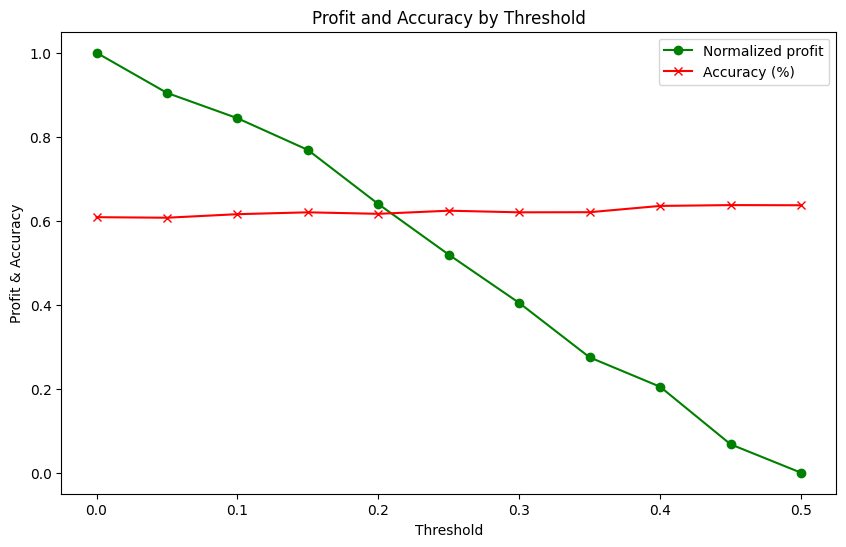

As we can see, the accuracy is almost constant, while the profit always goes down (that is why the best threshold is 0)


In [12]:
# As the best margin is 0, let's visualize the profit vs accuracy depending on the threshold

df_vis = pd.DataFrame(parameters, columns=['Threshold', 'Profit', 'Accuracy'])

# Normalize Profit 
df_vis['Profit_norm'] = (df_vis['Profit'] - df_vis['Profit'].min()) / (df_vis['Profit'].max() - df_vis['Profit'].min())

x, prof, acc = df_vis['Threshold'], df_vis['Profit_norm'], df_vis['Accuracy']

plt.figure(figsize=(10, 6))
plt.plot(x, prof, label = 'Normalized profit', marker='o', color = 'green')
plt.plot(x, acc, label = 'Accuracy (%)', marker='x', color = 'red')
plt.xlabel('Threshold')
plt.ylabel('Profit & Accuracy')
plt.legend()
plt.title('Profit and Accuracy by Threshold')
plt.show()

print('As we can see, the accuracy is almost constant, while the profit always goes down (that is why the best threshold is 0)')

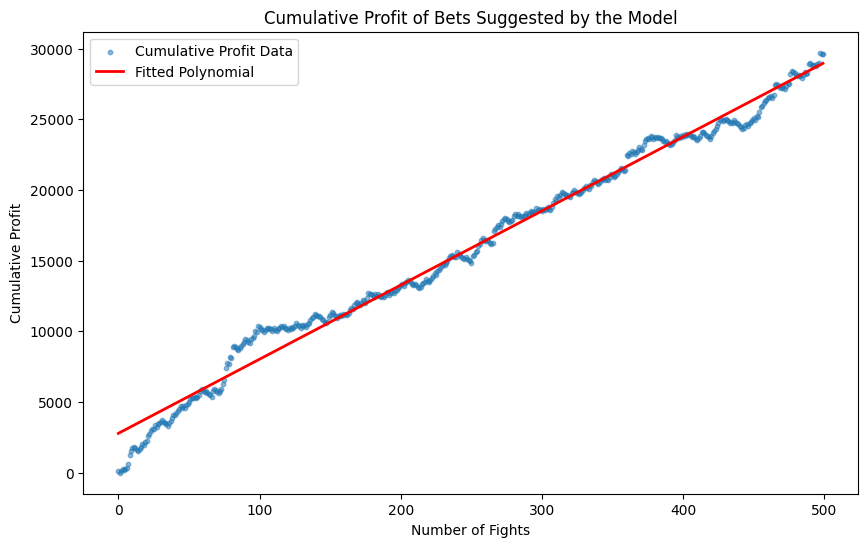

As we can see, the cumulative profit is increasing, so the model is profitable in the long run.


In [13]:
# bet_results is a list with the individual results of the bets suggested by the model
# Let's visualize the cumulative results of those bets
bet_results_cum = np.cumsum(bet_results)
x, y = range(len(bet_results_cum)), bet_results_cum
x_fit = np.linspace(min(x), max(x), 200)
y_fit = np.poly1d(np.polyfit(x, y, 1))(x_fit)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, s = 10, alpha = 0.5, label = 'Cumulative Profit Data')
plt.plot(x_fit, y_fit, color = 'red', linewidth = 2, label = 'Fitted Polynomial')
plt.xlabel('Number of Fights')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit of Bets Suggested by the Model')
plt.legend()
plt.show()

print('As we can see, the cumulative profit is increasing, so the model is profitable in the long run.')

## 📌 **Conclusions**

This notebook explored the application of a machine learning model to estimate the probability of victory for MMA fighters and assess the profitability of a data-driven betting strategy. The model's predictions were compared against the implied probabilities from betting odds, and bets were placed based on calculated expected value.

**Key takeaways** include:

The strategy achieved a **cumulative profit of $29,650 over 475 fights**, significantly outperforming a simple benchmark that bets on the implied favorite (which yielded ~$23,230).

The **Return on Investment (ROI) reached approximately 62.5%**, with a stable win rate within a 99% confidence interval of [55.1%, 66.6%].

The cumulative profit curve showed a clear upward trend with low variance, reinforcing the consistency of the strategy.

Profitability was more sensitive to the threshold parameter than accuracy, suggesting that small margins can significantly impact financial outcomes.

These results show the potential of using probabilistic machine learning models in betting contexts, especially when value-based conditions are carefully defined.